#  Multi-Output MLP for Side-Channel Analysis 
- ASCAD Dataset
    - No 1st order data leakage
    - Aligned (suitable for MLP) 
- Nonprofiled attack

- 256 different key guesses "k" 
    - each with it's own, individually tracked hidden network and loss
- LSB leakage model: $ L_k = \text{Sbox}[P \oplus k] \mod 2 $


# 1. Imports

In [34]:
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Hyperparameters
Ranked by estimated impact on model performance

In [35]:
LEARNING_RATE = 0.0005       # [1e-5, 1e-2]

SHARED_DIM = 0              # 0 = no shared layer, try [50, 100, 200]
BRANCH_LAYER_1 = 20         # Suggested range: [10, 50]
BRANCH_LAYER_2 = 10         # Suggested range: [5, 25]
OUTPUT_CLASSES = 2          # Binary classification (LSB leakage model)

NUM_TRACES = 10000          # For ASCAD: 10k -> 50k
TRACE_START_IDX = 0         # Starting index in dataset

BATCH_SIZE = 100            # [32, 256]

NUM_EPOCHS = 30             # Researchers see success in ~6 epochs

TARGET_BYTE_IDX = 2         # ASCAD shows 2nd-order leakage at byte index 2

## 2. Dataset Loading 

In [36]:
FILE_PATH = 'datasets/ASCADv1/ASCAD.h5'

AES_Sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

def load_ascad(file_path, num_traces, start_idx, target_byte):
    with h5py.File(file_path, 'r') as f: # h5 dataset structured file with traces and metadata
        # Profiling_traces for the training set
        traces = f['Profiling_traces']['traces'][start_idx : start_idx + num_traces]
        metadata = f['Profiling_traces']['metadata'][start_idx : start_idx + num_traces]
        
        # Only interested in specific byte of plaintext
        plaintexts = metadata['plaintext'][:, target_byte] 
        real_key = metadata['key'][0, target_byte]
        
    return traces, plaintexts, real_key

traces, plaintexts, real_key = load_ascad(
    FILE_PATH, 
    num_traces=NUM_TRACES, 
    start_idx=TRACE_START_IDX, 
    target_byte=TARGET_BYTE_IDX
)

# Normalize traces
traces = (traces - np.mean(traces, axis=0)) / np.std(traces, axis=0)
# Convert to Tensor
traces_tensor = torch.tensor(traces, dtype=torch.float32).unsqueeze(1) 
traces_tensor = traces_tensor.squeeze(1) # MLP takes (N, 700)
print("Traces shape:", traces_tensor.shape)
print("Real Key Byte:", hex(real_key))

Traces shape: torch.Size([10000, 700])
Real Key Byte: 0xe0


## 3. Label Generation

We generate 256 sets of labels, one for each key candidate.

In [37]:
def generate_labels(plaintexts):
    # Returns: (N, 256) where each entry is the label for that key guess
    labels = np.zeros((len(plaintexts), 256), dtype=np.longlong)
    
    for k in range(256):
        val = AES_Sbox[plaintexts ^ k] # We XOR the key guess to p, the result we will cross reference with the Sbox lookup table 
        labels[:, k] = val & 1         # LSB here, some use MSB
        
    return torch.tensor(labels, dtype=torch.long)

labels_tensor = generate_labels(plaintexts)
print("Labels shape:", labels_tensor.shape)

Labels shape: torch.Size([10000, 256])


## 4. Multi-Output Model Architecture

- Shared Layer (optional): Research shows 200 is most efficient for compute
- 256 Branches: Dense(20) -> ReLU -> Dense(10) -> ReLU -> Dense(2)

In [38]:
class MultiOutputNet(nn.Module):
    def __init__(self, input_dim, shared_dim, branch_l1, branch_l2, output_classes):
        super(MultiOutputNet, self).__init__()
        self.shared_dim = shared_dim
        
        if shared_dim > 0:
            self.shared_layer = nn.Sequential(
                nn.Linear(input_dim, shared_dim),
                nn.ReLU()
            )
            branch_input = shared_dim
        else:
            self.shared_layer = nn.Identity()
            branch_input = input_dim
            
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Linear(branch_input, branch_l1),
                nn.ReLU(),
                nn.Linear(branch_l1, branch_l2),
                nn.ReLU(),
                nn.Linear(branch_l2, output_classes)
            ) for _ in range(256)
        ])

    def forward(self, x):
        # x: (Batch, InputDim)
        shared = self.shared_layer(x)
        
        outs = []
        for branch in self.branches:
            outs.append(branch(shared))
        
        # Stack to (Batch, 256, 2)
        return torch.stack(outs, dim=1)

input_dim = traces_tensor.shape[1]  # Dynamically get input dimension
model = MultiOutputNet(
    input_dim=input_dim,
    shared_dim=SHARED_DIM,
    branch_l1=BRANCH_LAYER_1,
    branch_l2=BRANCH_LAYER_2,
    output_classes=OUTPUT_CLASSES
).to(device)

print(f"Model created with input_dim={input_dim}, shared_dim={SHARED_DIM}, branches={BRANCH_LAYER_1}→{BRANCH_LAYER_2}→{OUTPUT_CLASSES}")

Model created with input_dim=700, shared_dim=0, branches=20→10→2


## 5. Training Loop

- Loss Per-branch: $\mathcal{L}^{[k]} = -\frac{1}{N_s}\sum y_{true} \ln(z)$ (cross-entropy)
- Total Loss: - Total: $\mathcal{L}_{total} = \frac{1}{256}\sum_{k=1}^{256} \mathcal{L}^{[k]}$ (mean for gradient stability)
- Optimizer: Adam

In [39]:
dataset = TensorDataset(traces_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

history_loss = []

# To track scores of each key guess (higher score = more likely correct key)
# Score = negative loss, so correct key (lowest loss) has highest score
key_scores = np.zeros((NUM_EPOCHS, 256))

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data) # (Batch, 256, 2)
        
        # Compute loss: Average of CrossEntropy per branch
        # For each branch k, compute CrossEntropyLoss, then average over all 256 branches
        loss = 0
        for k in range(256):
            loss += criterion(output[:, k, :], target[:, k])
        loss = loss / 256
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1} Avg Loss: {total_loss / len(loader)}")
    
    # Validation: Check loss per branch on the whole set (or subset)
    model.eval()
    with torch.no_grad():
        # Compute full validation loss per branch
        # To avoid OOM, do in batches
        val_accum_loss = torch.zeros(256, device=device)
        val_count = 0
        
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            out = model(data) # (B, 256, 2)
            
            # Compute loss per branch alone
            for k in range(256):
                val_accum_loss[k] += nn.CrossEntropyLoss(reduction='sum')(out[:, k, :], target[:, k])
            
            val_count += data.size(0)
            
        avg_branch_losses = val_accum_loss / val_count
        # Convert loss to score: negate so that lower loss = higher score
        key_scores[epoch] = -avg_branch_losses.cpu().numpy()
        
        # Rank keys by score (descending - highest score is best)
        sorted_keys = np.argsort(key_scores[epoch])[::-1]  # Reverse for descending order
        best_score_key = sorted_keys[0]
        rank_of_real = np.where(sorted_keys == real_key)[0][0]
        
        print(f"Best Key: {hex(best_score_key)}, Real Key Rank: {rank_of_real}, Real Key Score: {key_scores[epoch][real_key]:.4f}")

Epoch 1/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.74it/s]


Epoch 1 Avg Loss: 0.6968777769804001
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6865


Epoch 2/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.79it/s]


Epoch 2 Avg Loss: 0.6937403684854507
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6749


Epoch 3/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.67it/s]


Epoch 3 Avg Loss: 0.6922476220130921
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6645


Epoch 4/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.78it/s]


Epoch 4 Avg Loss: 0.691054607629776
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6624


Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.78it/s]


Epoch 5 Avg Loss: 0.6897647821903229
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6518


Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.71it/s]


Epoch 6 Avg Loss: 0.68854436814785
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6471


Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


Epoch 7 Avg Loss: 0.6871772253513336
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6458


Epoch 8/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.75it/s]


Epoch 8 Avg Loss: 0.6857060503959655
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6468


Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.65it/s]


Epoch 9 Avg Loss: 0.6841482299566269
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6409


Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.74it/s]


Epoch 10 Avg Loss: 0.6824295246601104
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6378


Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


Epoch 11 Avg Loss: 0.6804735535383224
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6303


Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.75it/s]


Epoch 12 Avg Loss: 0.6785418313741683
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6280


Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


Epoch 13 Avg Loss: 0.676426802277565
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6274


Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.69it/s]


Epoch 14 Avg Loss: 0.6740786111354828
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6211


Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


Epoch 15 Avg Loss: 0.6716099208593369
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6193


Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.63it/s]


Epoch 16 Avg Loss: 0.6689688539505005
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6315


Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.67it/s]


Epoch 17 Avg Loss: 0.666250422000885
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6109


Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.76it/s]


Epoch 18 Avg Loss: 0.663391010761261
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6154


Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.71it/s]


Epoch 19 Avg Loss: 0.6604975491762162
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6004


Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.74it/s]


Epoch 20 Avg Loss: 0.6573751503229142
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6121


Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.74it/s]


Epoch 21 Avg Loss: 0.6541766440868377
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5954


Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.69it/s]


Epoch 22 Avg Loss: 0.6510044616460801
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5925


Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.74it/s]


Epoch 23 Avg Loss: 0.6475937998294831
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5947


Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.70it/s]


Epoch 24 Avg Loss: 0.6442866092920303
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5790


Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.70it/s]


Epoch 25 Avg Loss: 0.6405261313915253
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5773


Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.76it/s]


Epoch 26 Avg Loss: 0.6367819452285767
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5777


Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.65it/s]


Epoch 27 Avg Loss: 0.633511358499527
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5752


Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.63it/s]


Epoch 28 Avg Loss: 0.6298132622241974
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5638


Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


Epoch 29 Avg Loss: 0.6261254268884658
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5594


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.71it/s]


Epoch 30 Avg Loss: 0.6222185772657395
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5544


## 6. Results Analysis

Visualize the attack results with multiple charts.

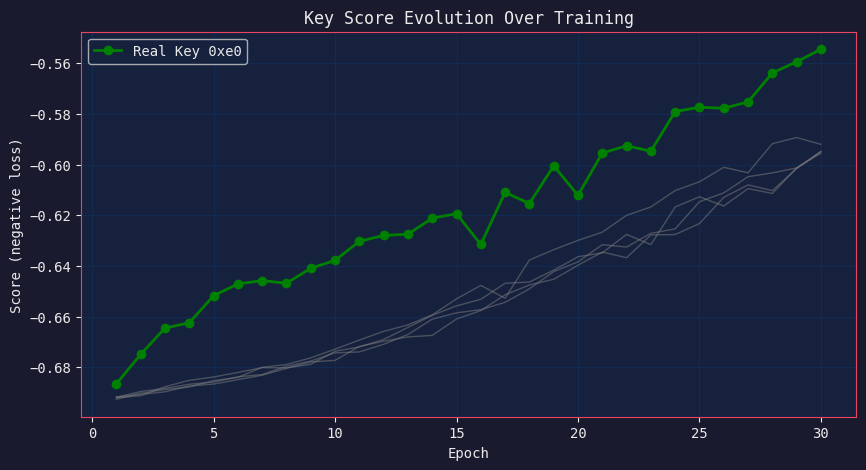

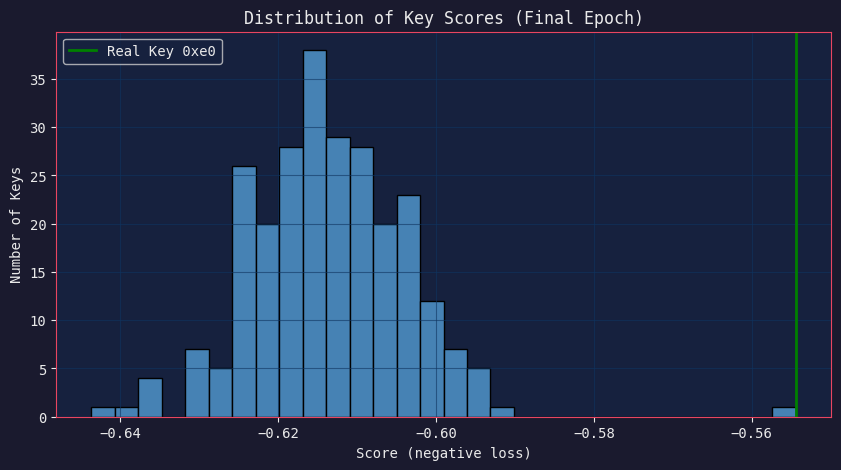

In [42]:
# Get the final scores for all 256 key guesses
final_scores = key_scores[-1]
epochs_range = np.arange(1, NUM_EPOCHS + 1)

# Calculate the rank of the real key at each epoch
real_key_ranks = []
for epoch in range(NUM_EPOCHS):
    sorted_keys = np.argsort(key_scores[epoch])[::-1]  # Sort by score (highest first)
    rank = np.where(sorted_keys == real_key)[0][0] + 1  # +1 for 1-based ranking
    real_key_ranks.append(rank)

# ---- Chart 1: Key Score Evolution ----
plt.figure(figsize=(10, 5))

# Plot a few wrong keys in gray
sorted_final = np.argsort(final_scores)[::-1]
for k in sorted_final[:5]:
    if k != real_key:
        plt.plot(epochs_range, key_scores[:, k], color='gray', alpha=0.5, linewidth=1)

# Plot the real key in green
plt.plot(epochs_range, key_scores[:, real_key], color='green', linewidth=2, 
         marker='o', label=f'Real Key {hex(real_key)}')

plt.xlabel('Epoch')
plt.ylabel('Score (negative loss)')
plt.title('Key Score Evolution Over Training')
plt.legend()
plt.grid(True)
plt.show()

# ---- Chart 2: Score Distribution at Final Epoch ----
plt.figure(figsize=(10, 5))

plt.hist(final_scores, bins=30, color='steelblue', edgecolor='black')
plt.axvline(x=final_scores[real_key], color='green', linewidth=2, label=f'Real Key {hex(real_key)}')

plt.xlabel('Score (negative loss)')
plt.ylabel('Number of Keys')
plt.title('Distribution of Key Scores (Final Epoch)')
plt.legend()
plt.grid(True)
plt.show()



In [41]:
# Print summary
print("=" * 50)
print("ATTACK SUMMARY")
print("=" * 50)
print(f"Target Key Byte:  {hex(real_key)}")
print(f"Final Rank:       {real_key_ranks[-1]}")
print(f"Final Score:      {final_scores[real_key]:.4f}")

if real_key_ranks[-1] == 1:
    print("Result:           KEY RECOVERED!")
else:
    print(f"Result:           Key not recovered (rank {real_key_ranks[-1]})")
print("=" * 50)

ATTACK SUMMARY
Target Key Byte:  0xe0
Final Rank:       1
Final Score:      -0.5544
Result:           KEY RECOVERED!
